# Tutorial: Coding an AutoEncoder in Tensorflow

What is an AutoEncoder?

The AutoEncoder network is  

***
Let's first import some useful libraries:

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
def lrelu(X, alpha=0.1):
    return tf.maximum(alpha*X, X)


***
Let's also import the training set

In [3]:
mnist = tf.keras.datasets.mnist
(X_train, _), (X_test, _) = mnist.load_data()

Draw a sample


 Sample: 



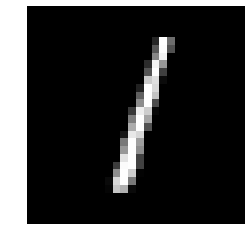

In [4]:
sample = 2 #chose one sample in the training set

X_train = X_train.astype(np.float32).reshape(-1,28*28)/X_train.max()
X_test = X_test.astype(np.float32).reshape(-1,28*28)/X_train.max()

print('\n Sample: \n')
plt.imshow(X_test[sample].reshape(28,28), cmap='gray');
plt.axis('off');


## Layer class definition

This class provides the definition of a dense layer. A dense layer is characterized by its trainable weights:

- a matrix W of dimensions (m_input, m_output)
- a bias vector b of dimensions (m_output)

The Layer class possesses the ```forward``` method which performs the linear forward propagation:

$$
Z_{out}= X_{in} \times W(m_{in},m_{out})+b(m_{out})
$$

Let's code it:

In [12]:
class Layer(object):
    
    def __init__(self, mi, mo, name):
        
        """
        This is the init method of the class Layer:
        It defines the class itself and contains the
        definition of the parameters that will be used by
        the other class' methods (i.e. forward)
        
        """
        # we are creating a dense layer, it's trainable parameters
        # are the matrix W of dimensions (mi, mo) and the biases
        # vectors that has dimension (mo)
        
        self.W = tf.get_variable(name='W_%s' %name,        # this name identifies uniquely the matrix W
                                 shape=(mi, mo),           # this assigns to the matrix the needed shape
                                 initializer=tf.glorot_uniform_initializer()) # you can choose among
                                                                              # many different distributions
                                                                              # to initialize your weights with
        
        self.b = tf.get_variable(name="b_%s" %name,        # this name identifies uniquely the bias vector b 
                                 shape=(mo,),              
                                 initializer=tf.zeros_initializer(),) # biases can be initialized as zeros
        
    def forward(self, X):
        
        """
        This is the forward propagation method of the class Layer
        """
        # the method forward performs the following forward propagation 
        # operation on the input tensor X. Don't worry about back  
        # propagation, tensorflow will handle it
        
        Z=tf.matmul(X,self.W)+self.b
        
        return Z
        
        

## Creating the AutoEncoder Network

Blablabla

In [37]:
class AutoEncoder(object):
    
    def __init__(self, input_dim, layer_dims, 
                learning_rate, epochs, batch_size):
        
        # Note: all of what has self in front of it will be reused outside the init method!
        #       thus we make promote some constants to attributes of the class
        
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        
        """
        The AutoEncoder (AE) class is initialized by providing the number of features of the 
        input (in this case 28*28) and a list of integers named layers_dims.
        It contains the number of the nodes for the intermediate layers and is of the kind:
        
        layer_dims= [
                     output_nodes_layer_1,
                     output_nodes_layer_2,
                     output_nodes_layer_3,
                     ...
                     output_nodes_layer_n
                     ]
                     
        """
        # Write code here
        self.layer_dims = layer_dims 

        """
        
        The AE architecture has a butterfly shape and thus we reverse the previous 
        list of shapes to obtain:
        
        reversed_layer_dims = [
                               output_nodes_layer_(n-1),
                               output_nodes_layer_(n-2),
                               ...
                               output_nodes_layer_2,
                               output_nodes_layer_1,
                               ]
        """
        # Write code here
        self.reversed_layer_dims= list(reversed(layer_dims))[1:] #Note: We exclude layer n
        
        """
        
        Now we define the placeholder for our input tensor X_in, and create 2 empty lists
        named encoder_layers and decoder_layers that will contain the layers of our AE
        
        """
        
        #Write code here
        self.X_in = tf.placeholder(tf.float32, shape=(None, input_dim))
        
        self.encoder_layers = []
        self.decoder_layers = []
        
        
        """
        
        We miss one last ingredient to build our AE: a method that builds the network ,
        it will be called build_network
        
        
        """
        # Write code here
        self.build_network(input_dim)
        
    
    """
    Let's define what this build network method does:
    
    """
    #Write code here
    def build_network(self, input_dim):
        
        """
        STEP 1: BUILDING THE NETWORK
        
        the method build_network creates the graph that represents the network. It 
        does this by making use of two for loops, the first defines the encoder layers
        """
        
        """
        ENCODER LAYERS
        """
        # Write code here
        mi = input_dim    #input size
        count=0           #set a counter for layers' names
        
        for mo in self.layer_dims:           # loop over a list [mo_1, mo_2, ..., mo_(n-1), mo_n]
                                             # of intermediate layer dimensions
                
            layer = Layer(mi, mo, count)     # for each intermediate layer dimension create a layer
                                             # named 'count' with associated weights of shape W(mi, mo) b(mo)
                
            self.encoder_layers.append(layer)# add the created layer to the list of encoder layers
            count+=1                         # and increase the counter
            mi = mo                          # the input dimension mi of the next layer will be the ouput
                                             # dimension of the previous one
        
        #Note: in this way the class is created independently of the size of the network! the actual
        #      list of layer dimensions is given later!
            
        """
        DECODER LAYERS
        """
        # We repeat the same operations, but in reverse order to create the right hand-side of the butterfly
        # the decoder
        
        #Write code here
        for mo in self.reversed_layer_dims:   # loop over a list [mo_(n-1), mo_(n-2), ..., mo_2, mo_1]  
            
            layer = Layer(mi, mo, count)      # create the layer here
            
            self.decoder_layers.append(layer) # append the layer to the decoder layers list
            count+=1                          # increase the counter and
            mi = mo                           # update the output dimensions
            
        # Note that the last mo is not the input size, so, to compare
        # the input of the network with the ouput 
        
        output_layer = Layer(mi,input_dim, count)   # we'll have to create one last layer
                                                    # of dimensions (mi, input_dim):
        self.decoder_layers.append(output_layer)    # and append it to the list of decoder layers
        
    
        """
        
        STEP 2: BUILDING THE GRAPH
        
        Now that the network has been built, we want to 
        define how the input will propagate through the encoder and the decoder.
        
        The overall forward propagation of each side of the network is
        the propagation through each single layer and is carried out by the
        "encode" and "decode" functions:
        
        """
    
        self.Z = self.encode(self.X_in) # Propagation of the input through the encoder. 
                                        # This outputs the latent vector self.Z
            
        self.X_hat = self.decode(self.Z)    # Propagation of the latent vector self.Z
                                        # through the decoder, last output is unactivated 
                                        # on purpose (will be clearer later)
        
        """
        
        STEP 3: DEFINING THE LOSS and THE OPTIMIZATION ALGORITHM
        
        With the two last steps we created the network and the graph of operations
        that propagate the input until the network output X_hat. Now we have to define
        The loss function, i.e. that positive number, function of the network
        parameters that has to be minimized during training.
        
        """
        
        """
        LOSS
        """
        
        # write code here
        self.loss = tf.reduce_sum(tf.square(self.X_in - self.X_hat))
        # reduce_sum converts a tensor to a scalar sum of its components
                    
        """
        
        OPTIMIZATION ALGORITHM
        
        Define the loss minimization algorithm, we chose Adaptive momentum optimizer (Adam) for 
        this purpose. Everytime train_op will be called, one step of gradient minimization will
        be taken.
        """
        # write code here
        self.train_op = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss)
                                                #set the learning rate                #what to minimize
        
    """
    We now define the last two functions: encode and decode which we used previously
    in STEP 2 
    """
    # write code here
    def encode(self, X):                                # This method takes as input a sample X
                                                        # and outputs its encoded form Z
        
        output=X
        
        for layer in self.encoder_layers:               # This loop propagates the input X
                                                        # through the encoder layers using
            output = layer.forward(output)              # their forward method
            output = lrelu(output)
            
        return output                                   # vector in latent space, Z
        
    def decode(self,Z):                                 # This method takes a vector Z in the 
                                                        # latent space and decodes it to X_hat
                                                        # living in the space of the samples
        output=Z
        
        for layer in self.decoder_layers:               # Loop through the decoder network,  
            
            output = layer.forward(output)
            output = tf.nn.sigmoid(output)
            
        return output
    
    
    def fit(self, X, show_fig=True):                    # Fit method of the class AutoEncoder
         
        losses = []                                     # a list containing the losses
        n_batches = len(X) // self.batch_size
        
        print("Training AutoEncoder")
        print("n_batches:", n_batches)
        for i in range(self.epochs):
            
            print("epoch:", i)
            np.random.shuffle(X)
        
            for j in range(n_batches):                  # the training cycle in one epoch:
            
                X_batch = X[j*self.batch_size:(j+1)*self.batch_size] # the batch to pass for computation
                _, l, = self.session.run((self.train_op, self.loss), 
                                         feed_dict={self.X_in: X_batch}) #running one step of gradient
                l /= self.batch_size                                     #minimization

                losses.append(l)
                
                # let's add some intermediate printouts to see how the training is going
                if j % 80*self.batch_size == 0:        

                    print("iter: %d, cost: %.3f" % (j, l))
            
        if show_fig:
            plt.plot(losses)
            plt.show()


    def predict(self, X):                              # function to test the network once training
                                                       # is completed
        
        return self.session.run(self.X_hat, feed_dict={self.X_in: X})


    def set_session(self, session):
        
        self.session = session
        

In [38]:
def test_single_autoencoder():
    
    
    _, input_dimensions = X_train.shape     # Lets get the input_dimensions from the dataset

    tf.reset_default_graph()                # Resetting any previously defined graph
    
                    
    dae = AutoEncoder(input_dim=input_dimensions, # Create your very own network here!!
                      layer_dims=[500,300,100], 
                      learning_rate=0.0008, 
                      epochs=15, batch_size=100)

    
    init_op=tf.global_variables_initializer() # Define the network's variables initializer
    
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.10)
    
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options )) as sess:
        
        sess.run(init_op)     # Initialize the network variables in this sess
        dae.set_session(sess) # Set it for the AutoEncoder you defined previously
        
        dae.fit(X_train)      # Call the fit method that you defined previously
        

        # Testing the created network performances on the test set!
        done = False
        while not done:
            i = np.random.choice(len(X_test))
            x = X_test[i]
            y = dae.predict([x]).reshape(28, 28)

            plt.subplot(1,2,1)
            plt.imshow(x.reshape(28, 28), cmap='gray')
        
            plt.title("Original")
            plt.subplot(1,2,2)
            plt.imshow(y, cmap='gray')
            plt.title("Reconstruction")
            plt.show()

            ans = input("Generate another?")
            if ans and ans[0] in ('n' or 'N'):
                  done = True

Training AutoEncoder
n_batches: 600
epoch: 0
iter: 0, cost: 190.182
iter: 80, cost: 52.454
iter: 160, cost: 41.031
iter: 240, cost: 34.324
iter: 320, cost: 29.384
iter: 400, cost: 28.085
iter: 480, cost: 25.471
iter: 560, cost: 24.099
epoch: 1
iter: 0, cost: 24.549
iter: 80, cost: 22.252
iter: 160, cost: 19.382
iter: 240, cost: 19.840
iter: 320, cost: 17.803
iter: 400, cost: 15.697
iter: 480, cost: 16.734
iter: 560, cost: 17.482
epoch: 2
iter: 0, cost: 15.362
iter: 80, cost: 14.885
iter: 160, cost: 14.697
iter: 240, cost: 14.536
iter: 320, cost: 12.520
iter: 400, cost: 13.098
iter: 480, cost: 10.920
iter: 560, cost: 12.230
epoch: 3
iter: 0, cost: 12.117
iter: 80, cost: 10.047
iter: 160, cost: 11.320
iter: 240, cost: 11.274
iter: 320, cost: 11.695
iter: 400, cost: 10.083
iter: 480, cost: 9.978
iter: 560, cost: 9.126
epoch: 4
iter: 0, cost: 7.999
iter: 80, cost: 10.690
iter: 160, cost: 9.470
iter: 240, cost: 8.309
iter: 320, cost: 9.096
iter: 400, cost: 8.597
iter: 480, cost: 8.465
iter:

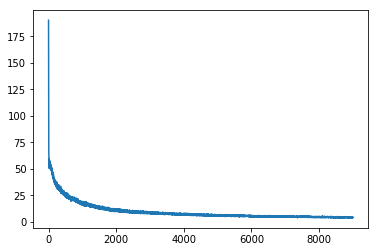

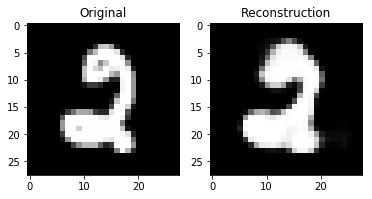

Generate another?


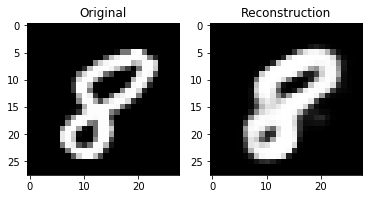

Generate another?


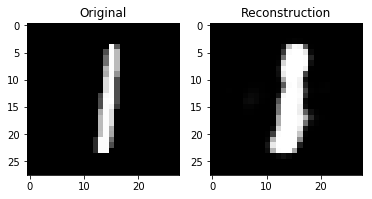

Generate another?n


In [39]:
if __name__ == '__main__':
    test_single_autoencoder()
